In [435]:
# run model for predict f1 races
#imports 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, mean_squared_error

In [436]:
import optuna
print(optuna.__version__)

4.5.0


In [437]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [438]:
# odczyt w pliku danych thesis_f1_final_model.csv
data = pd.read_csv('../../datasets/thesis_final_model_f1_data.csv')
data.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,rainfall_max,wind_speed_mean,final_position
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,2
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,16
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,17
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,9
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297,1


In [439]:
# after baku 2145, 31
data.shape

(2154, 31)

In [ ]:
X = data.drop(columns=['final_position'])
y = data['final_position']

In [ ]:
# usuniecie driver_number (bo teoretycznie driver_number okresla kierowce, a my chcemy przewidziec final_position na podstawie innych cech)
#X = X.drop(columns=['driver_number'])

In [441]:
X.head()

,driver_number,broadcast_name,country_code_x,year,session_name,date_start,time_start,date_end,time_end,gmt_offset,...,num_safety_car_deployed,num_yellow_flags,num_double_yellow_flags,penalty_seconds,air_temp_mean,track_temp_mean,humidity_mean,pressure_mean,rainfall_max,wind_speed_mean
0,1,M VERSTAPPEN,NED,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
1,2,L SARGEANT,USA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
2,4,L NORRIS,GBR,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
3,10,P GASLY,FRA,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297
4,11,S PEREZ,MEX,2023,Race,2023-03-19,17:00:00,2023-03-19,19:00:00,03:00:00,...,1,3,2,0,26.091892,31.792568,57.790541,1010.92973,0.0,1.772297


In [442]:
y.head

<bound method NDFrame.head of 0        2
1       16
2       17
3        9
4        1
        ..
2149     3
2150     1
2151     1
2152    19
2153    19
Name: final_position, Length: 2154, dtype: int64>

In [443]:
def categorize_position(pos):
    if pos == 1:
        return 'winner'
    elif pos in [2, 3]:
        return 'top3'
    elif 4 <= pos <= 10:
        return 'points'
    else:
        return 'no_points'

In [444]:
# y to categorize final position
y = y.apply(categorize_position)
y.head()


0         top3
1    no_points
2    no_points
3       points
4       winner
Name: final_position, dtype: object

In [445]:
print("Unikalne kategorie przed kodowaniem:", y.unique())

Unikalne kategorie przed kodowaniem: ['top3' 'no_points' 'points' 'winner']


In [446]:
#change name final_position to final_position_category
y.rename('final_position_category', inplace=True)

0            top3
1       no_points
2       no_points
3          points
4          winner
          ...    
2149         top3
2150       winner
2151       winner
2152    no_points
2153    no_points
Name: final_position_category, Length: 2154, dtype: object

In [447]:
# wyswitel informacje o zbiorze danych
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

#wyswietl cechy
print("Features in X:", X.columns.tolist())
# wyswietl unikalne kategorie pozycji
print("Unique position categories in y:", y.unique())
print(X.dtypes)

Shape of X: (2154, 30)
Shape of y: (2154,)
Features in X: ['driver_number', 'broadcast_name', 'country_code_x', 'year', 'session_name', 'date_start', 'time_start', 'date_end', 'time_end', 'gmt_offset', 'starting_position', 'wins_before', 'pit_stops_count', 'avg_pit_stop_duration', 'qualifying_position_y', 'num_stints', 'used_soft', 'used_medium', 'used_hard', 'num_red_flags', 'num_safety_car_deployed', 'num_yellow_flags', 'num_double_yellow_flags', 'penalty_seconds', 'air_temp_mean', 'track_temp_mean', 'humidity_mean', 'pressure_mean', 'rainfall_max', 'wind_speed_mean']
Unique position categories in y: ['top3' 'no_points' 'points' 'winner']
driver_number                int64
broadcast_name              object
country_code_x              object
year                         int64
session_name                object
date_start                  object
time_start                  object
date_end                    object
time_end                    object
gmt_offset                  object
s

In [448]:
# encode data in X and scale it
from sklearn.preprocessing import LabelEncoder, StandardScaler

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])



In [449]:
print("Kolejność klas (LabelEncoder):", le.classes_)

Kolejność klas (LabelEncoder): ['-03:00:00' '-04:00:00' '-05:00:00' '-06:00:00' '-08:00:00' '01:00:00'
 '02:00:00' '03:00:00' '04:00:00' '08:00:00' '09:00:00' '10:00:00'
 '11:00:00']


In [450]:
# scale data with StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [451]:
#split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

In [452]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [453]:
# compute specificity   
def compute_specificity(conf_mat):
    specificity = []
    for i in range(conf_mat.shape[0]):
        TP = conf_mat[i, i]
        FP = conf_mat[:, i].sum() - TP
        FN = conf_mat[i, :].sum() - TP
        TN = conf_mat.sum() - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity.append(spec)
    return specificity

In [454]:
# hyperparameter tuning with Optuna
from sklearn.linear_model import LogisticRegression

def objective(trial, kfolds, X_train, y_train, X_valid, y_valid):
    # hyperparameters to tune

    # random forest
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 50, 150)
    rf_max_depth = trial.suggest_int("rf_max_depth", 3, 15)

    # gradient boosting
    gb_n_estimators = trial.suggest_int("gb_n_estimators", 50, 150)
    gb_learning_rate = trial.suggest_float("gb_learning_rate", 0.01, 0.3)
    gb_max_depth = trial.suggest_int("gb_max_depth", 2, 10)

    # SVM
    svm_C = trial.suggest_float("svm_C", 0.1, 10.0, log=True)
    svm_kernel = trial.suggest_categorical("svm_kernel", ["linear", "rbf"])

    # models to ensemble
    clf_rf = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                    max_depth=rf_max_depth, 
                                    random_state=42)
    clf_gb = GradientBoostingClassifier(n_estimators=gb_n_estimators, 
                                        learning_rate=gb_learning_rate,
                                        max_depth=gb_max_depth, 
                                        random_state=42)
    
    clf_svm = SVC(C=svm_C, 
                  kernel=svm_kernel, 
                  probability=True, 
                  random_state=42)


    # ensemble model 
    ensemble = VotingClassifier(
        estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
        voting='soft'
    )

    le = LabelEncoder()
    le.fit(y_train)  # lub y_valid, ważne by to były kategorie tekstowe

    # encode labels using the fitted label encoder 'le'
    y_train_enc = le.transform(y_train)
    y_valid_enc = le.transform(y_valid)

    class_labels = le.classes_

    # cross-validation setup
    kf = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)

    # lists to store metrics for each fold
    acc_list, prec_list, rec_list, f1_list, spec_list = [], [], [], [], []
    mse_list, rmse_list, logloss_list = [], [], []

    # new metrics lists
    prec_macro_list, prec_weighted_list = [], []
    rec_macro_list, rec_weighted_list = [], []
    f1_macro_list, f1_weighted_list = [], []

    # globally summed confusion matrix
    conf_mat_sum = np.zeros((len(np.unique(y_train_enc)), len(np.unique(y_train_enc))), dtype=int)

    # cross-validation loop
    for train_index, test_index in kf.split(X_train, y_train_enc):
        X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_te = y_train_enc[train_index], y_train_enc[test_index]

        ensemble.fit(X_tr, y_tr)
        y_pred_cv = ensemble.predict(X_te)
        y_proba_cv = ensemble.predict_proba(X_te)

        conf_mat_cv = confusion_matrix(y_te, y_pred_cv)
        conf_mat_sum += conf_mat_cv  # each fold summed to global confusion matrix

        acc_list.append(accuracy_score(y_te, y_pred_cv))
        prec_list.append(precision_score(y_te, y_pred_cv, average="micro", zero_division=0))
        rec_list.append(recall_score(y_te, y_pred_cv, average="micro", zero_division=0))
        f1_list.append(f1_score(y_te, y_pred_cv, average="micro", zero_division=0))

        # new metrics calculations
        prec_macro_list.append(precision_score(y_te, y_pred_cv, average="macro", zero_division=0))
        prec_weighted_list.append(precision_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        rec_macro_list.append(recall_score(y_te, y_pred_cv, average="macro", zero_division=0))
        rec_weighted_list.append(recall_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        f1_macro_list.append(f1_score(y_te, y_pred_cv, average="macro", zero_division=0))
        f1_weighted_list.append(f1_score(y_te, y_pred_cv, average="weighted", zero_division=0))

        spec_cv = np.mean(compute_specificity(conf_mat_cv))
        spec_list.append(spec_cv)

        mse_list.append(mean_squared_error(y_te, y_pred_cv))
        rmse_list.append(np.sqrt(mse_list[-1]))
        logloss_list.append(log_loss(y_te, y_proba_cv))

    # average and std of metrics across folds
    acc, acc_std = np.mean(acc_list), np.std(acc_list, ddof=0)
    prec, prec_std = np.mean(prec_list), np.std(prec_list, ddof=0)
    rec, rec_std = np.mean(rec_list), np.std(rec_list, ddof=0)
    f1, f1_std = np.mean(f1_list), np.std(f1_list, ddof=0)
    spec, spec_std = np.mean(spec_list), np.std(spec_list, ddof=0)

    mse, mse_std = np.mean(mse_list), np.std(mse_list, ddof=0)
    rmse, rmse_std = np.mean(rmse_list), np.std(rmse_list, ddof=0)
    logloss, logloss_std = np.mean(logloss_list), np.std(logloss_list, ddof=0)

    # new metrics averages and stds
    prec_macro, prec_macro_std = np.mean(prec_macro_list), np.std(prec_macro_list, ddof=0)
    prec_weighted, prec_weighted_std = np.mean(prec_weighted_list), np.std(prec_weighted_list, ddof=0)

    rec_macro, rec_macro_std = np.mean(rec_macro_list), np.std(rec_macro_list, ddof=0)
    rec_weighted, rec_weighted_std = np.mean(rec_weighted_list), np.std(rec_weighted_list, ddof=0)

    f1_macro, f1_macro_std = np.mean(f1_macro_list), np.std(f1_macro_list, ddof=0)
    f1_weighted, f1_weighted_std = np.mean(f1_weighted_list), np.std(f1_weighted_list, ddof=0)


    # set metrics to return 
    trial.set_user_attr("accuracy", acc)
    trial.set_user_attr("accuracy_std", acc_std)
    trial.set_user_attr("precision", prec)
    trial.set_user_attr("precision_std", prec_std)
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("recall_std", rec_std)
    trial.set_user_attr("f1_score", f1)
    trial.set_user_attr("f1_std", f1_std)
    trial.set_user_attr("specificity_avg", spec)
    trial.set_user_attr("specificity_std", spec_std)

    trial.set_user_attr("mse", mse)
    trial.set_user_attr("mse_std", mse_std)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("rmse_std", rmse_std)
    trial.set_user_attr("logloss", logloss)
    trial.set_user_attr("logloss_std", logloss_std)

    # set new metrics to return
    trial.set_user_attr("precision_macro", prec_macro)
    trial.set_user_attr("precision_macro_std", prec_macro_std)

    trial.set_user_attr("recall_macro", rec_macro)
    trial.set_user_attr("recall_macro_std", rec_macro_std)

    trial.set_user_attr("f1_macro", f1_macro)
    trial.set_user_attr("f1_macro_std", f1_macro_std)

    # save confusion matrix
    trial.set_user_attr("confusion_matrix", conf_mat_sum.tolist())

    trial.set_user_attr("class_labels", class_labels)

    # return metric to optimize
    return f1  # or acc if you are optimizing accuracy


In [455]:
def show_best_parameters_and_metrics(study):
    best_trial = study.best_trial
    best_params = best_trial.params

    print("🎯 Najlepsze hiperparametry:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # print("--- Mikro ---")
    # print(f"F1-score (micro): {best_trial.user_attrs['f1_score']:.4f} ± {best_trial.user_attrs['f1_std']:.4f}")
    # print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")
    # print(f"Precision (micro): {best_trial.user_attrs['precision']:.4f} ± {best_trial.user_attrs['precision_std']:.4f}")
    # print(f"Recall / Sensitivity (micro): {best_trial.user_attrs['recall']:.4f} ± {best_trial.user_attrs['recall_std']:.4f}")

    # print("\n--- Makro ---")
    # print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    # print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    # print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")

    print("\n📊 Metryki najlepszej próby:")
    print(f"F1-score (macro): {best_trial.user_attrs['f1_macro']:.4f} ± {best_trial.user_attrs['f1_macro_std']:.4f}")
    print(f"Precision (macro): {best_trial.user_attrs['precision_macro']:.4f} ± {best_trial.user_attrs['precision_macro_std']:.4f}")
    print(f"Recall / Sensitivity (macro): {best_trial.user_attrs['recall_macro']:.4f} ± {best_trial.user_attrs['recall_macro_std']:.4f}")
    print(f"Specificity (avg): {best_trial.user_attrs['specificity_avg']:.4f} ± {best_trial.user_attrs['specificity_std']:.4f}")
    print(f"Accuracy: {best_trial.user_attrs['accuracy']:.4f} ± {best_trial.user_attrs['accuracy_std']:.4f}")

    print("\n🧮 Confusion Matrix:")
    print(np.array(best_trial.user_attrs["confusion_matrix"]))

    confusion_matrix_sum = np.array(best_trial.user_attrs["confusion_matrix"])
    class_labels = best_trial.user_attrs["class_labels"]

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_sum, 
                                display_labels=class_labels)
    disp.plot(ax=ax, cmap='Reds', values_format='d')
    plt.title("Sumaryczna macierz pomyłek (cross-val)")
    plt.show()

In [456]:
def get_best_ensemble(best_params):
    clf_rf = RandomForestClassifier(
        n_estimators=best_params['rf_n_estimators'],
        max_depth=best_params['rf_max_depth'],
        random_state=42
    )
    clf_gb = GradientBoostingClassifier(
        n_estimators=best_params['gb_n_estimators'],
        learning_rate=best_params['gb_learning_rate'],
        max_depth=best_params['gb_max_depth'],
        random_state=42
    )
    clf_svm = SVC(
        C=best_params['svm_C'],
        kernel=best_params['svm_kernel'],
        probability=True,
        random_state=42
    )
    ensemble = VotingClassifier(
        estimators=[('rf', clf_rf), ('gb', clf_gb), ('svm', clf_svm)],
        voting='soft'
    )
    return ensemble

In [457]:
# run the optimization
study = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
study.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid), n_trials=50)

[I 2025-09-22 21:15:56,202] A new study created in memory with name: no-name-0c02a1c0-1499-4d69-8b50-c89b3c967aa7
[I 2025-09-22 21:16:35,005] Trial 0 finished with value: 0.7856570812523377 and parameters: {'rf_n_estimators': 108, 'rf_max_depth': 10, 'gb_n_estimators': 128, 'gb_learning_rate': 0.11161264308701786, 'gb_max_depth': 10, 'svm_C': 0.16103482505088862, 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7856570812523377.
[I 2025-09-22 21:16:42,507] Trial 1 finished with value: 0.7067017227343733 and parameters: {'rf_n_estimators': 104, 'rf_max_depth': 13, 'gb_n_estimators': 134, 'gb_learning_rate': 0.03025076761524799, 'gb_max_depth': 2, 'svm_C': 0.11530719645424886, 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7856570812523377.
[I 2025-09-22 21:17:11,651] Trial 2 finished with value: 0.7922883984950826 and parameters: {'rf_n_estimators': 140, 'rf_max_depth': 7, 'gb_n_estimators': 104, 'gb_learning_rate': 0.1732445414934701, 'gb_max_depth': 10, 'svm_C': 1.264656197323

🎯 Najlepsze hiperparametry:
rf_n_estimators: 115
rf_max_depth: 15
gb_n_estimators: 120
gb_learning_rate: 0.08642237574832005
gb_max_depth: 5
svm_C: 0.5358567036680584
svm_kernel: linear

📊 Metryki najlepszej próby:
F1-score (macro): 0.7229 ± 0.0379
Precision (macro): 0.7864 ± 0.0336
Recall / Sensitivity (macro): 0.6909 ± 0.0422
Specificity (avg): 0.9168 ± 0.0127
Accuracy: 0.7956 ± 0.0303

🧮 Confusion Matrix:
[[659  86   4   2]
 [ 95 415  17   2]
 [  8  55  83   5]
 [  2  15  17  42]]


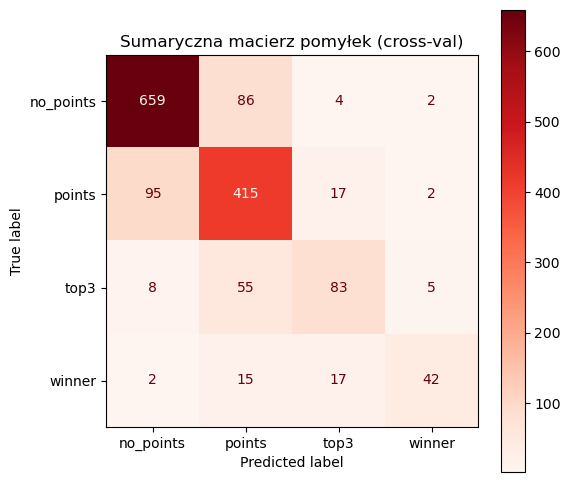

In [ ]:
show_best_parameters_and_metrics(study)

### SELEKCJA CECH

In [459]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

required_features = ['driver_number', 'broadcast_name', 'session_name']
other_features = [col for col in X_train.columns if col not in required_features]
selector = SelectKBest(score_func=f_classif, k=15)
X_train_sel = selector.fit_transform(X_train[other_features], y_train)
selected_other = [other_features[i] for i, sel in enumerate(selector.get_support()) if sel]
final_features = required_features + selected_other
X_train_selected = X_train[final_features]
X_valid_selected = X_valid[final_features]

In [460]:
print("Wybrane cechy:", final_features)

Wybrane cechy: ['driver_number', 'broadcast_name', 'session_name', 'country_code_x', 'date_start', 'date_end', 'starting_position', 'wins_before', 'pit_stops_count', 'avg_pit_stop_duration', 'qualifying_position_y', 'num_stints', 'used_soft', 'used_medium', 'used_hard', 'num_red_flags', 'num_double_yellow_flags', 'penalty_seconds']


In [461]:
# run the optimization
study_selected = optuna.create_study(direction="maximize")
#trials = 50, kfolds = 5
study_selected.optimize(lambda trial: objective(trial, kfolds=5, X_train=X_train_selected, y_train=y_train, X_valid=X_valid_selected, y_valid=y_valid), n_trials=50)

[I 2025-09-22 21:30:17,442] A new study created in memory with name: no-name-97664fe6-1e6f-45f7-80fd-955dc8d93fd7
[I 2025-09-22 21:30:22,987] Trial 0 finished with value: 0.7558007524586917 and parameters: {'rf_n_estimators': 70, 'rf_max_depth': 14, 'gb_n_estimators': 86, 'gb_learning_rate': 0.20832503838014158, 'gb_max_depth': 2, 'svm_C': 2.848285393426581, 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7558007524586917.
[I 2025-09-22 21:30:29,379] Trial 1 finished with value: 0.7684077358033927 and parameters: {'rf_n_estimators': 56, 'rf_max_depth': 6, 'gb_n_estimators': 75, 'gb_learning_rate': 0.2519715157362362, 'gb_max_depth': 4, 'svm_C': 0.1043049824298373, 'svm_kernel': 'linear'}. Best is trial 1 with value: 0.7684077358033927.
[I 2025-09-22 21:30:38,970] Trial 2 finished with value: 0.7949572066621197 and parameters: {'rf_n_estimators': 117, 'rf_max_depth': 15, 'gb_n_estimators': 148, 'gb_learning_rate': 0.25484721458412024, 'gb_max_depth': 3, 'svm_C': 0.1004958114095692, 

🎯 Najlepsze hiperparametry:
rf_n_estimators: 81
rf_max_depth: 12
gb_n_estimators: 123
gb_learning_rate: 0.0691212017244864
gb_max_depth: 7
svm_C: 8.129521622403493
svm_kernel: linear

📊 Metryki najlepszej próby:
F1-score (macro): 0.7346 ± 0.0332
Precision (macro): 0.7716 ± 0.0424
Recall / Sensitivity (macro): 0.7111 ± 0.0317
Specificity (avg): 0.9224 ± 0.0096
Accuracy: 0.8049 ± 0.0239

🧮 Confusion Matrix:
[[664  80   5   2]
 [ 85 416  24   4]
 [  3  53  88   7]
 [  0  17  14  45]]


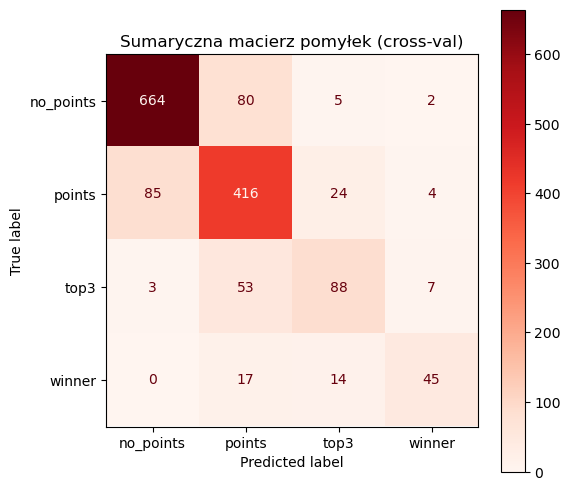

In [462]:
show_best_parameters_and_metrics(study_selected)